## DengAI competition
The goal of this competition is to build a model that predicts the number of Dengue cases in San Juan and Iquitos

- [X] Create a time split 80 - 20 per city (there are more years to train and predict for sj than iq)
- [X] Create a basic baseline model with all features 'as is' (bad performance expected)
- [X] Create a basic model only non-correlated features
- [X] One model per city
- [X] Normalize features
- [X] Obtain feature importance
- [ ] Implement time delay using moving averages

In [68]:
import pandas as pd
import os
import seaborn as sns
from dateutil import parser
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
tqdm.pandas()
import numpy as np
import hydra
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
import lightgbm as lgb
import copy
from sklearn.model_selection import train_test_split

In [69]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

### Load data

In [70]:
data_folder = 'data'
features_train_path = 'dengue_features_train.csv'
labels_train_path = 'dengue_labels_train.csv'
features_test_path = 'dengue_features_test.csv'

In [71]:
features_train = pd.read_csv(os.path.join(data_folder, features_train_path))
labels_train = pd.read_csv(os.path.join(data_folder, labels_train_path))
features_test = pd.read_csv(os.path.join(data_folder, features_test_path))

### Basic Pre-processing

In [72]:
# transform week_start_date into a datetime feature
features_train['week_start_date'] = features_train.progress_apply(lambda x: parser.parse(x.week_start_date), axis=1)

  0%|          | 0/1456 [00:00<?, ?it/s]

In [73]:
# Merge features and labels for easier exploration
train_df = features_train.merge(labels_train, on=['city', 'year', 'weekofyear'])

In [74]:
# train_df['weekofyear'] = train_df.apply(lambda x: x.weekofyear if x.weekofyear != 53 else 0, axis=1)

In [75]:
def fill_ma(df, col):
    df[col+'_MA'] =  df[col].fillna(df[col].mean()).rolling(2).mean().tolist()
    df[col] = df.apply(lambda x: x[col] if not np.isnan(x[col]) else x[col+'_MA'], axis=1)
    df.drop(columns=[col+'_MA'], inplace=True)

In [76]:
def plot(df):
    ax = df.plot(x='week_start_date', y='total_cases', label='Real')
    df.plot(ax = ax, x='week_start_date', y='pred', label='Pred')
    plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
    plt.legend()
    plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

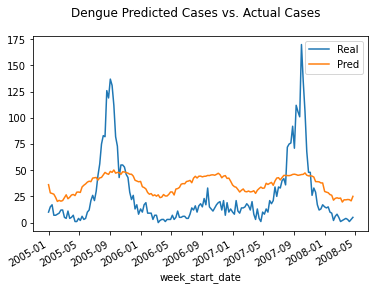

sj sklearn.neural_network.MLPRegressor 24.70537490202352


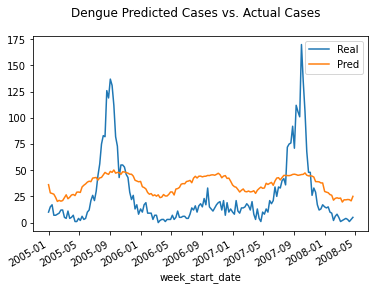

sj sklearn.svm.SVR 16.181309392124177


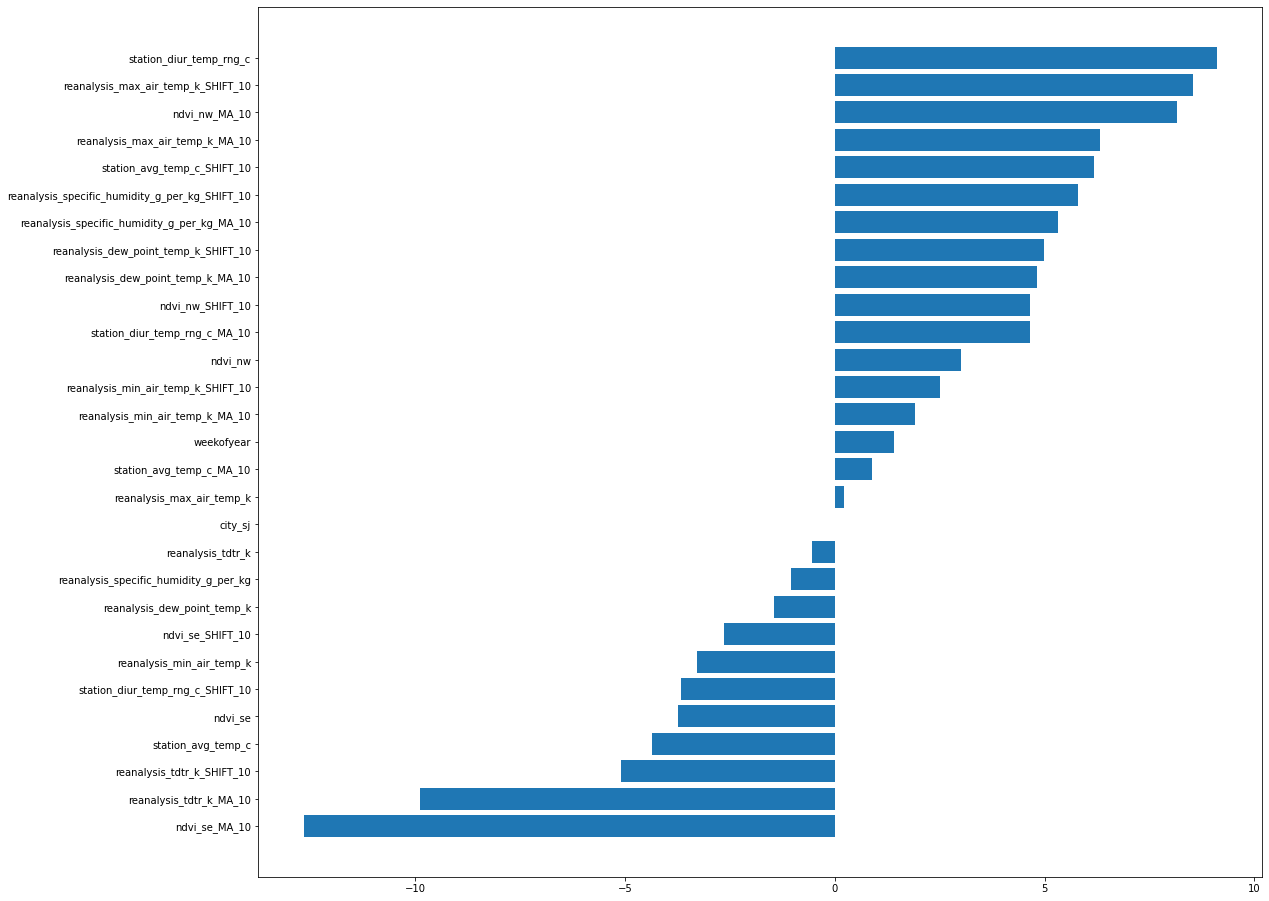

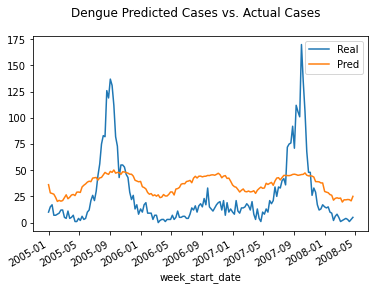

sj sklearn.svm.SVR 17.16419880104499


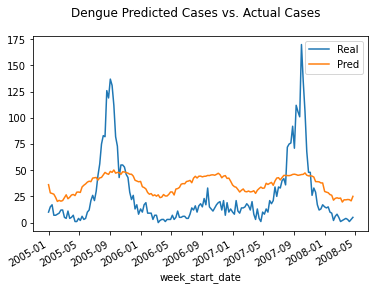

sj sklearn.tree.DecisionTreeRegressor 26.884393063583815


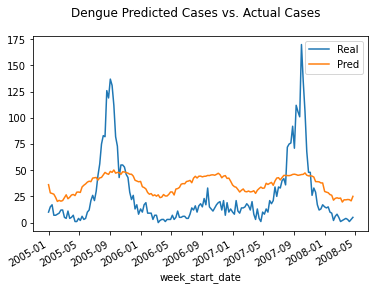

sj sklearn.ensemble.RandomForestRegressor 21.12150289017341


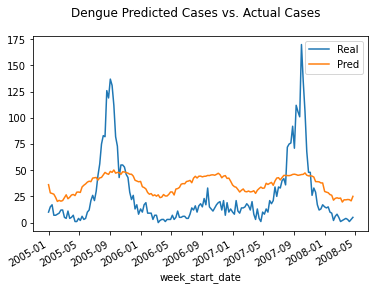

sj sklearn.linear_model.PassiveAggressiveRegressor 21.34798103371264


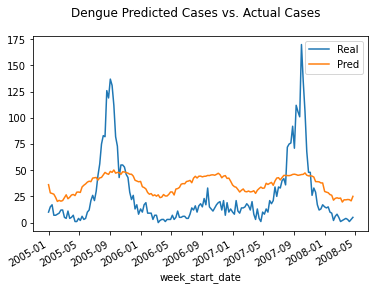

sj sklearn.linear_model.SGDRegressor 21.590172727466197


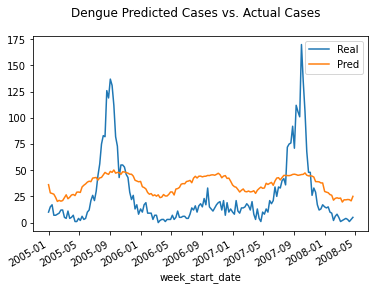

sj sklearn.gaussian_process.GaussianProcessRegressor 63.53534236382057


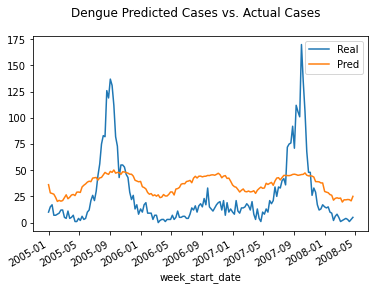

sj LGB1 23.740385201864232
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 1137.81	valid_0's l1: 28.0841
[100]	valid_0's l2: 1124.47	valid_0's l1: 27.7485
[150]	valid_0's l2: 1113.07	valid_0's l1: 27.4475
[200]	valid_0's l2: 1100.35	valid_0's l1: 27.1705
[250]	valid_0's l2: 1091.61	valid_0's l1: 26.8862
[300]	valid_0's l2: 1085.85	valid_0's l1: 26.6345
[350]	valid_0's l2: 1078.82	valid_0's l1: 26.4393
[400]	valid_0's l2: 1073.53	valid_0's l1: 26.2915
[450]	valid_0's l2: 1064.24	valid_0's l1: 26.0876
[500]	valid_0's l2: 1053.79	valid_0's l1: 25.8773
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 1053.79	valid_0's l1: 25.8773


c:\users\basla\documents\projects\dengai\dengai\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\users\basla\documents\projects\dengai\dengai\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\users\basla\documents\projects\dengai\dengai\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

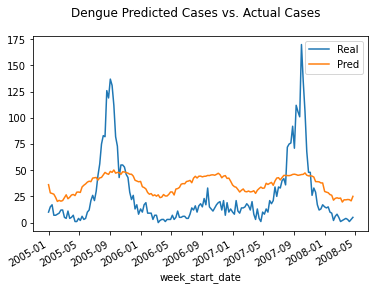

sj LGB2 25.877290442543803


  0%|          | 0/20 [00:00<?, ?it/s]

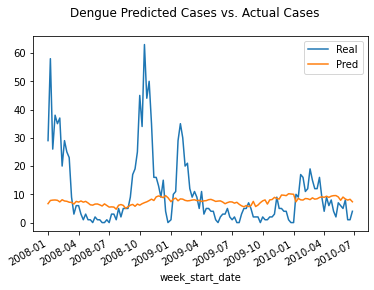

iq sklearn.neural_network.MLPRegressor 8.234652872395376


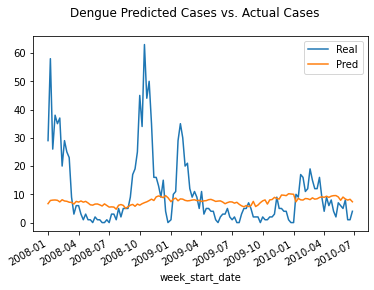

iq sklearn.svm.SVR 8.079637742308044


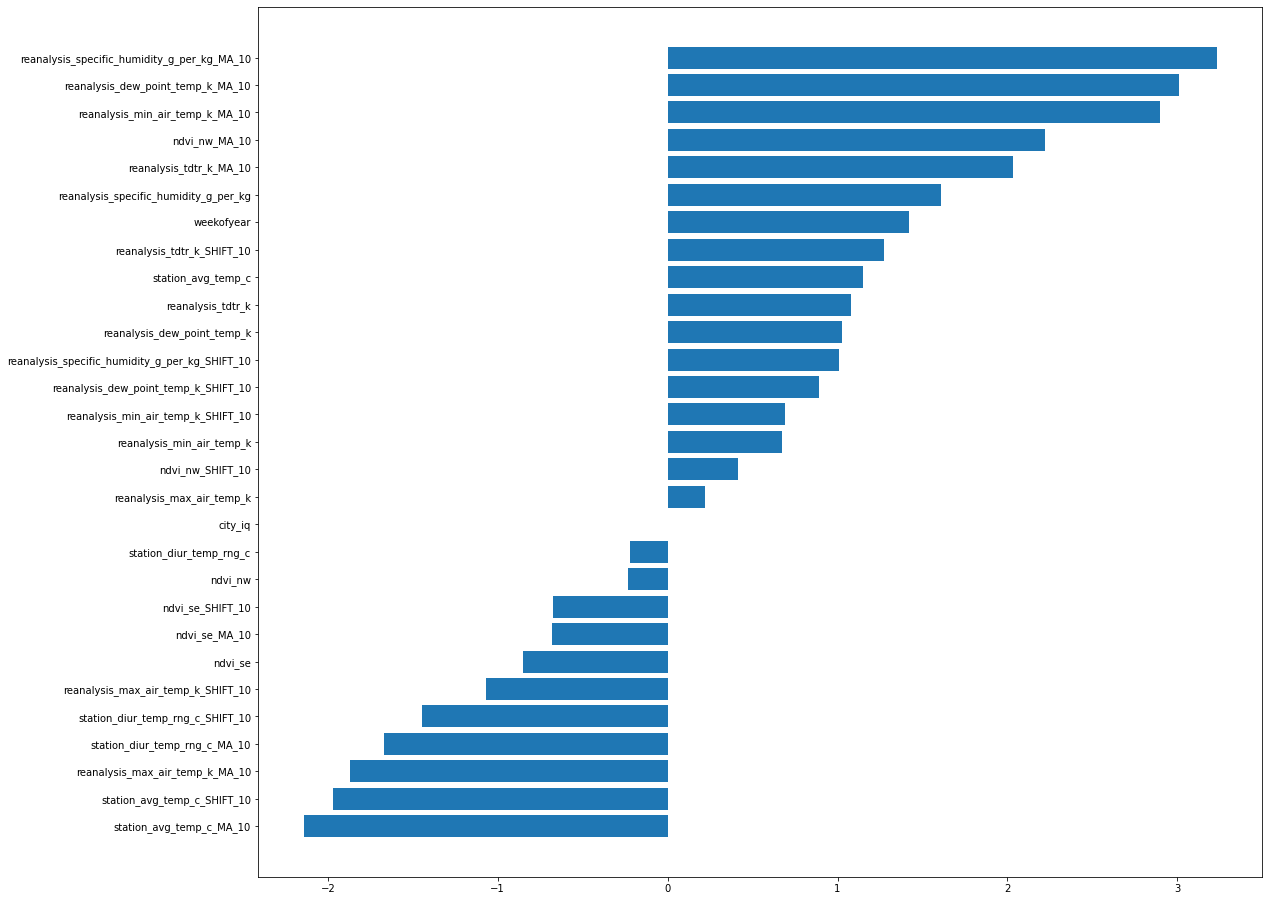

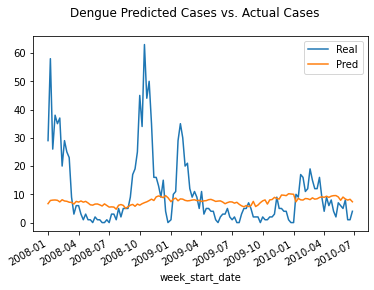

iq sklearn.svm.SVR 7.795163442241765


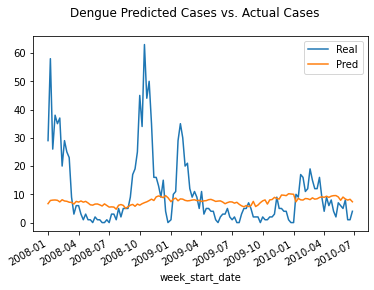

iq sklearn.tree.DecisionTreeRegressor 11.215384615384615


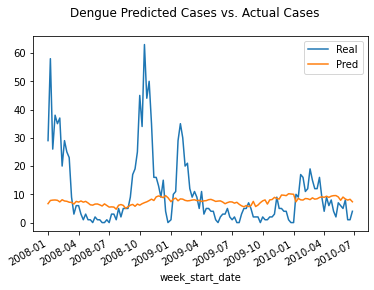

iq sklearn.ensemble.RandomForestRegressor 9.213692307692305


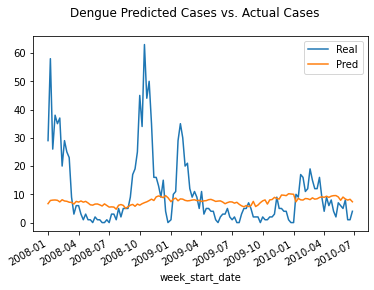

iq sklearn.linear_model.PassiveAggressiveRegressor 10.02448260171367


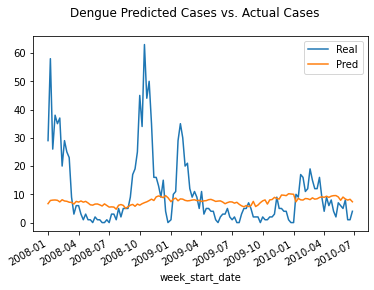

iq sklearn.linear_model.SGDRegressor 8.289616381847047


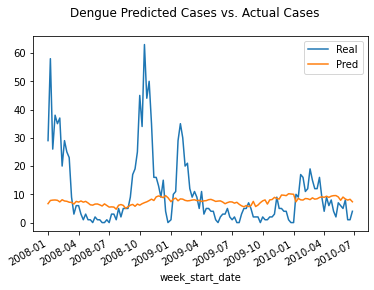

iq sklearn.gaussian_process.GaussianProcessRegressor 13.907636916641156


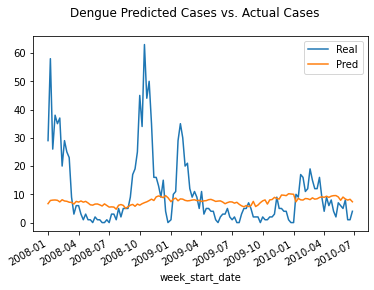

iq LGB1 8.638094243245705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 170.596	valid_0's l1: 8.2533
[100]	valid_0's l2: 169.524	valid_0's l1: 8.2134
[150]	valid_0's l2: 168.751	valid_0's l1: 8.18848
[200]	valid_0's l2: 168.197	valid_0's l1: 8.16197
[250]	valid_0's l2: 167.779	valid_0's l1: 8.15029
[300]	valid_0's l2: 167.52	valid_0's l1: 8.14956
[350]	valid_0's l2: 167.315	valid_0's l1: 8.1484
[400]	valid_0's l2: 167.089	valid_0's l1: 8.15078
Early stopping, best iteration is:
[362]	valid_0's l2: 167.268	valid_0's l1: 8.14776


c:\users\basla\documents\projects\dengai\dengai\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\users\basla\documents\projects\dengai\dengai\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\users\basla\documents\projects\dengai\dengai\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

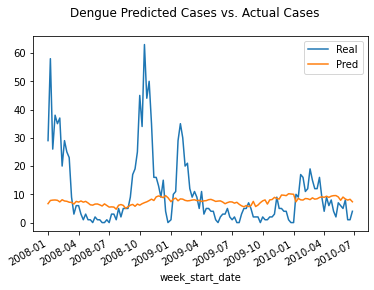

iq LGB2 8.147756092709747


In [81]:
data_collect = {
    'iq': {
        'y_real':None,
        'y_pred':{
            
        }
    },
    'sj': {
        'y_real':None, 
        'y_pred':{
            
        }
    }
}
for city in ['sj', 'iq']:
    city_df = copy.deepcopy(train_df[train_df.city == city])
    fill_ma_cols = [col for col in city_df.columns if city_df[city_df[col].isna()].shape[0] > 0]
    for col in tqdm(fill_ma_cols):
        city_df[col].fillna(method='ffill', inplace=True)
    for col in list(city_df.select_dtypes(include=np.number).columns):
        if col not in ["year", "weekofyear", "total_cases"]:
            for s in [10]:
                city_df[col + "_SHIFT_" + str(s)] = city_df.groupby("city")[col].shift(s).fillna(city_df[col].mean())
                city_df[col + "_MA_" + str(s)] = city_df[col].rolling(s).mean().fillna(city_df[col].mean())
            
    train_years = sorted(city_df['year'].drop_duplicates().values)[:int(city_df['year'].nunique() * 0.8)]
    eval_years = sorted(city_df['year'].drop_duplicates().values)[int(city_df['year'].nunique() * 0.8):]
    
    city_train_df = city_df.loc[city_df.year.isin(train_years)].copy()
    city_eval_df = city_df.loc[city_df.year.isin(eval_years)].copy()

#     city_train_df, city_eval_df = train_test_split(city_df, test_size=0.2, random_state=5)
    initial_list = [
    'weekofyear',
#      'ndvi_ne',
     'ndvi_nw',
     'ndvi_se',
#      'ndvi_sw',
#      'precipitation_amt_mm',
#      'reanalysis_air_temp_k',
#      'reanalysis_avg_temp_k',
     'reanalysis_dew_point_temp_k',
     'reanalysis_max_air_temp_k',
     'reanalysis_min_air_temp_k',
#      'reanalysis_precip_amt_kg_per_m2',
#      'reanalysis_relative_humidity_percent',
#      'reanalysis_sat_precip_amt_mm',
     'reanalysis_specific_humidity_g_per_kg',
     'reanalysis_tdtr_k',
     'station_avg_temp_c',
     'station_diur_temp_rng_c',
#      'station_max_temp_c',
#      'station_min_temp_c',
#      'station_precip_mm',
     'total_cases']
    final_list = []
    for col in initial_list:
        final_list.append(col)
        if col not in ['total_cases', 'weekofyear']:
            for s in [10]:
                final_list.append(col + '_MA_' + str(s))
                final_list.append(col + '_SHIFT_' + str(s))
    initial_list = final_list
    TARGET = 'total_cases'
    ignore_cols = ['week_start_date'] + [TARGET]
    num_cols = [col for col in initial_list if col not in ignore_cols]
    cat_cols = [col for col in [col for col in city_train_df.columns if col not in list(city_train_df.select_dtypes(include=np.number).columns)] if col not in ignore_cols]
    
    features_train = city_train_df[num_cols].join(pd.get_dummies(city_train_df[cat_cols]))
    feature_names = list(features_train.columns)
    features_train = features_train.values
    label_train = city_train_df[TARGET].values
    features_eval = city_eval_df[num_cols].join(pd.get_dummies(city_eval_df[cat_cols])).values
    label_eval = city_eval_df[TARGET].values
    
    data_collect[city]['y_real'] = label_eval
     
    scaler = 'sklearn.preprocessing.MinMaxScaler'
    scaler = hydra.utils.get_class(scaler)()
    scaler.fit(features_train)
    features_train = scaler.transform(features_train)
    features_eval = scaler.transform(features_eval)
    
    model = 'sklearn.neural_network.MLPRegressor'
    clf = hydra.utils.get_class(model)(hidden_layer_sizes=(8,4,), early_stopping=True, random_state = 5)
    clf = clf.fit(features_train, label_train)
    y_hat = clf.predict(features_eval)
    data_collect[city]['y_pred'][model] = y_hat
    city_eval_df.loc[:, 'pred'] = y_hat
    plot(city_eval_df)
    print(city, model, mean_absolute_error(label_eval, y_hat))
#     y_hat = clf.predict(features_train)
#     city_train_df.loc[:, 'pred'] = y_hat
#     plot(city_train_df)
#     print(city, model, mean_absolute_error(label_train, y_hat))
    
    model = 'sklearn.svm.SVR'
    clf = hydra.utils.get_class(model)(kernel="linear")
    clf = clf.fit(features_train, label_train)
    y_hat = clf.predict(features_eval)
    data_collect[city]['y_pred'][model+'LIN'] = y_hat
    plot(city_eval_df)
    print(city, model, mean_absolute_error(label_eval, y_hat))
#     y_hat = clf.predict(features_train)
#     city_train_df.loc[:, 'pred'] = y_hat
#     plot(city_train_df)
#     print(city, model, mean_absolute_error(label_train, y_hat))
    def f_importances(coef, names):
        figure(figsize=(18, 16))
        imp = coef
        imp,names = zip(*sorted(zip(imp,names)))
        plt.barh(range(len(names)), imp, align='center')
        plt.yticks(range(len(names)), names)
        plt.show()
    f_importances(clf.coef_[0], feature_names)
    
    model = 'sklearn.svm.SVR'
    clf = hydra.utils.get_class(model)()
    clf = clf.fit(features_train, label_train)
    y_hat = clf.predict(features_eval)
    data_collect[city]['y_pred'][model] = y_hat
    plot(city_eval_df)
    print(city, model, mean_absolute_error(label_eval, y_hat))
#     y_hat = clf.predict(features_train)
#     city_train_df.loc[:, 'pred'] = y_hat
#     plot(city_train_df)
#     print(city, model, mean_absolute_error(label_train, y_hat))
    
    model = 'sklearn.tree.DecisionTreeRegressor'
    clf = hydra.utils.get_class(model)(random_state=5)
    clf = clf.fit(features_train, label_train)
    y_hat = clf.predict(features_eval)
    data_collect[city]['y_pred'][model] = y_hat
    plot(city_eval_df)
    print(city, model, mean_absolute_error(label_eval, y_hat))
#     y_hat = clf.predict(features_train)
#     city_train_df.loc[:, 'pred'] = y_hat
#     plot(city_train_df)
#     print(city, model, mean_absolute_error(label_train, y_hat))
    
    model = 'sklearn.ensemble.RandomForestRegressor'
    clf = hydra.utils.get_class(model)(random_state=5)
    clf = clf.fit(features_train, label_train)
    y_hat = clf.predict(features_eval)
    data_collect[city]['y_pred'][model] = y_hat
    plot(city_eval_df)
    print(city, model, mean_absolute_error(label_eval, y_hat))
#     y_hat = clf.predict(features_train)
#     city_train_df.loc[:, 'pred'] = y_hat
#     plot(city_train_df)
#     print(city, model, mean_absolute_error(label_train, y_hat))
    
    model = 'sklearn.linear_model.PassiveAggressiveRegressor'
    clf = hydra.utils.get_class(model)(random_state=5)
    clf = clf.fit(features_train, label_train)
    y_hat = clf.predict(features_eval)
    data_collect[city]['y_pred'][model] = y_hat
    plot(city_eval_df)
    print(city, model, mean_absolute_error(label_eval, y_hat))
#     y_hat = clf.predict(features_train)
#     city_train_df.loc[:, 'pred'] = y_hat
#     plot(city_train_df)
#     print(city, model, mean_absolute_error(label_train, y_hat))
    
    model = 'sklearn.linear_model.SGDRegressor'
    clf = hydra.utils.get_class(model)(random_state=5)
    clf = clf.fit(features_train, label_train)
    y_hat = clf.predict(features_eval)
    data_collect[city]['y_pred'][model] = y_hat
    plot(city_eval_df)
    print(city, model, mean_absolute_error(label_eval, y_hat))
#     y_hat = clf.predict(features_train)
#     city_train_df.loc[:, 'pred'] = y_hat
#     plot(city_train_df)
#     print(city, model, mean_absolute_error(label_train, y_hat))
    
    model = 'sklearn.gaussian_process.GaussianProcessRegressor'
    clf = hydra.utils.get_class(model)(random_state=5)
    clf = clf.fit(features_train, label_train)
    y_hat = clf.predict(features_eval)
    data_collect[city]['y_pred'][model] = y_hat
    plot(city_eval_df)
    print(city, model, mean_absolute_error(label_eval, y_hat))
#     y_hat = clf.predict(features_train)
#     city_train_df.loc[:, 'pred'] = y_hat
#     plot(city_train_df)
#     print(city, model, mean_absolute_error(label_train, y_hat))
    
    lgbm = lgb.LGBMRegressor(random_state=5)
    lgbm = lgbm.fit(features_train, label_train)
    y_hat = lgbm.predict(features_eval)
    data_collect[city]['y_pred']['LGB1'] = y_hat
    plot(city_eval_df)
    print(city, 'LGB1', mean_absolute_error(label_eval, y_hat))
#     y_hat = clf.predict(features_train)
#     city_train_df.loc[:, 'pred'] = y_hat
#     plot(city_train_df)
#     print(city, 'LGB1', mean_absolute_error(label_train, y_hat))
    
    lgb_train = lgb.Dataset(features_train, label_train)
    lgb_val = lgb.Dataset(features_eval, label_eval)
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'learning_rate': 0.001 ,
        'verbose': 0,
        'num_leaves': 5,
        'max_bin': 255,
        'verbose': 0,
        'num_rounds': 500,
    }
    lgbm_model = lgb.train(params, train_set = lgb_train, valid_sets = lgb_val, verbose_eval=50,early_stopping_rounds=50) 
    y_hat =  lgbm_model.predict(features_eval)
    data_collect[city]['y_pred']['LGB2'] = y_hat
    plot(city_eval_df)
    print(city, 'LGB2', mean_absolute_error(label_eval, y_hat))
#     y_hat = clf.predict(features_train)
#     city_train_df.loc[:, 'pred'] = y_hat
#     plot(city_train_df)
#     print(city, 'LGB2', mean_absolute_error(label_train, y_hat))

In [82]:
for model in data_collect['iq']['y_pred']:
    y_real = []
    y_hat = []
    for city in data_collect:
        y_real.extend(data_collect[city]['y_real'])
        for model_pred in data_collect[city]['y_pred']:
            if model_pred == model:
                y_hat.extend(data_collect[city]['y_pred'][model])
    print(model)
    print(mean_absolute_error(y_real, y_hat))

sklearn.neural_network.MLPRegressor
17.638728486671514
sklearn.svm.SVRLIN
12.705344657879632
sklearn.svm.SVR
13.144480660304332
sklearn.tree.DecisionTreeRegressor
20.16171617161716
sklearn.ensemble.RandomForestRegressor
16.01254125412541
sklearn.linear_model.PassiveAggressiveRegressor
16.489714379719683
sklearn.linear_model.SGDRegressor
15.88366340426326
sklearn.gaussian_process.GaussianProcessRegressor
42.24292748549277
LGB1
17.260854427539453
LGB2
18.27055953337408


In [42]:
for model in data_collect['iq']['y_pred']:
    y_real = []
    y_hat = []
    for city in data_collect:
        y_real.extend(data_collect[city]['y_real'])
        for model_pred in data_collect[city]['y_pred']:
            if model_pred == model:
                y_hat.extend(data_collect[city]['y_pred'][model])
    print(model)
    print(mean_absolute_error(y_real, y_hat))

sklearn.neural_network.MLPRegressor
17.13230362634938
sklearn.svm.SVRLIN
12.93172187596968
sklearn.svm.SVR
13.145046811840482
sklearn.tree.DecisionTreeRegressor
23.541254125412543
sklearn.ensemble.RandomForestRegressor
15.675478547854786
sklearn.linear_model.PassiveAggressiveRegressor
14.692532654639063
sklearn.linear_model.SGDRegressor
15.328942122019294
sklearn.gaussian_process.GaussianProcessRegressor
22.11855236678717
LGB1
15.882536158690375
LGB2
19.126877289784623


In [34]:
lgbm = lgb.LGBMRegressor()
lgbm = lgbm.fit(features_train, label_train)
y_hat = lgbm.predict(features_eval)
mean_absolute_error(label_eval, y_hat)

14.942237622741352

In [35]:
lgb_train = lgb.Dataset(features_train, label_train)
lgb_val = lgb.Dataset(features_eval, label_eval)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'learning_rate': 0.001 ,
    'verbose': 0,
    'num_leaves': 21,
    'max_bin': 21,
    'verbose': 0,
    'num_rounds': 20000,
}

In [36]:
lgbm_model = lgb.train(params, train_set = lgb_train, valid_sets = lgb_val, verbose_eval=10,early_stopping_rounds=50) 

c:\users\basla\documents\projects\dengai\dengai\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\users\basla\documents\projects\dengai\dengai\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\users\basla\documents\projects\dengai\dengai\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 50 rounds
[10]	valid_0's l1: 21.1498	valid_0's l2: 767.032
[20]	valid_0's l1: 21.0754	valid_0's l2: 764.086
[30]	valid_0's l1: 21.0018	valid_0's l2: 761.225
[40]	valid_0's l1: 20.9289	valid_0's l2: 758.448
[50]	valid_0's l1: 20.8559	valid_0's l2: 755.718
[60]	valid_0's l1: 20.7838	valid_0's l2: 753.078
[70]	valid_0's l1: 20.7134	valid_0's l2: 750.476
[80]	valid_0's l1: 20.6435	valid_0's l2: 747.924
[90]	valid_0's l1: 20.5727	valid_0's l2: 745.328
[100]	valid_0's l1: 20.5031	valid_0's l2: 742.839
[110]	valid_0's l1: 20.4339	valid_0's l2: 740.396
[120]	valid_0's l1: 20.3656	valid_0's l2: 738.024
[130]	valid_0's l1: 20.2984	valid_0's l2: 735.728
[140]	valid_0's l1: 20.231	valid_0's l2: 733.468
[150]	valid_0's l1: 20.1642	valid_0's l2: 731.279
[160]	valid_0's l1: 20.098	valid_0

[1700]	valid_0's l1: 15.3231	valid_0's l2: 600.82
[1710]	valid_0's l1: 15.3099	valid_0's l2: 600.261
[1720]	valid_0's l1: 15.2997	valid_0's l2: 599.872
[1730]	valid_0's l1: 15.2879	valid_0's l2: 599.32
[1740]	valid_0's l1: 15.2755	valid_0's l2: 598.737
[1750]	valid_0's l1: 15.2643	valid_0's l2: 598.205
[1760]	valid_0's l1: 15.2555	valid_0's l2: 597.901
[1770]	valid_0's l1: 15.2435	valid_0's l2: 597.319
[1780]	valid_0's l1: 15.2326	valid_0's l2: 596.808
[1790]	valid_0's l1: 15.2207	valid_0's l2: 596.25
[1800]	valid_0's l1: 15.2109	valid_0's l2: 595.845
[1810]	valid_0's l1: 15.2007	valid_0's l2: 595.446
[1820]	valid_0's l1: 15.1913	valid_0's l2: 595.106
[1830]	valid_0's l1: 15.1839	valid_0's l2: 594.878
[1840]	valid_0's l1: 15.1739	valid_0's l2: 594.692
[1850]	valid_0's l1: 15.1665	valid_0's l2: 594.658
[1860]	valid_0's l1: 15.1567	valid_0's l2: 594.489
[1870]	valid_0's l1: 15.1466	valid_0's l2: 594.246
[1880]	valid_0's l1: 15.134	valid_0's l2: 593.758
[1890]	valid_0's l1: 15.1209	valid_

In [37]:
y_hat =  lgbm_model.predict(features_eval)
mean_absolute_error(label_eval, y_hat)

14.684989274306776